


```

# $\color{blue}{Langchain}$

---

In [ ]:
# Link to file
from google.colab import drive

drive.mount("/content/drive")
%cd '/content/drive/MyDrive/'

---

### $\color{red}{LCEL}$

---

At a high level Langchain is library for interacting with LLMs, it has a extensive functionality and avoids us reinventing the wheel when we're dealing with LLMs.

The name Langchain is a hint at its underlying logic that we create a chain where an initial input will be passed to a module transformed and passed to the next, until it resurfaces as some final response.

This chaining is acomplished with Langchain's Runnable class, and the | pipe operator and is referred to as Langchain Expression Language.

---

---

##### $\color{orange}{Runnables}$

---

The most simple case we can imaging is using a prompt template and an LLM.

Let's install Langcahin

In [ ]:
%%capture
!pip install -U -q langchain

**Let's check the Prompt Template...**

In [ ]:
from langchain.prompts import ChatPromptTemplate

template = """Answer the question by referring to information in the context. If their is insufficient information in the context to answer the question then respond with 'No information.':

### CONTEXT
{context}

### QUESTION
Question: {input}
"""

qa_prompt = ChatPromptTemplate.from_template(template)

**What is it?**

In [ ]:
type(qa_prompt)

In [ ]:
from langchain_core.runnables import Runnable


In [ ]:
isinstance(qa_prompt, ChatPromptTemplate)

In [ ]:
isinstance(qa_prompt, Runnable)

**So we inherit from Runnable, what does it need?**

In [ ]:
qa_prompt.InputType

In [ ]:
qa_prompt.input_schema.schema()['properties']

In [ ]:
prompt_in = {
    'context': "Contrary to popular belief fish haven't always lived on land. As early as the third millenium they were known to also inhabit the sea",
    'input': "What do we know of fish's natural habitat?"
}

In [ ]:
prompt_out = qa_prompt.invoke(prompt_in)

**We get this HumanMessage object out with a string field call content**

In [ ]:
print(prompt_out.messages[0].content)

In [ ]:
type(prompt_out)

In [ ]:
prompt_out.messages[0].to_json()

**Let's get an LLM**

In [ ]:
import getpass
import os
openai_api_key = getpass.getpass("Enter your OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

In [ ]:
%%capture
!pip install langchain_openai

In [ ]:
from langchain_openai import ChatOpenAI

In [ ]:
qa_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature = 0)

In [ ]:
isinstance(qa_llm, ChatOpenAI)

In [ ]:
isinstance(qa_llm, Runnable)

**It's a runnable, what does it want**

In [ ]:
qa_llm.InputType

**It accepts a human message with a content field**

**Let's Invoke**

In [ ]:
llm_out = qa_llm.invoke(prompt_out)

In [ ]:
llm_out

**Invent a Human Message to see it works**

In [ ]:
from langchain_core.messages.human import HumanMessage

content = "Answer the question by referring to information in the context. Elaborate and invent other facts if you want.':\n\n### CONTEXT\nContrary to popular belief fish haven't always lived on land. As early as the third millenium they were known to also inhabit the sea\n\n### QUESTION\nQuestion: What do we know of our natural habitat?\n"
human_message = HumanMessage(content=content)

In [ ]:
qa_llm.invoke([human_message])

**So the LLM expects a list of messages or a prompt value. It returns another BaseMessage specifically and AIMessage**

**Let's run it through an output parser.**

In [ ]:
from langchain_core.output_parsers.string import StrOutputParser

In [ ]:
parser = StrOutputParser()

In [ ]:
isinstance(parser, StrOutputParser)

In [ ]:
isinstance(parser, Runnable)

In [ ]:
parser.InputType

In [ ]:
parser.output_schema.schema()

**let's invoke**

In [ ]:
parser_out = parser.invoke(llm_out)

In [ ]:
parser_out

In [ ]:
type(parser_out)

**So we see how we can just pass one output to another module, so let's make a chain**

In [ ]:
chain = qa_prompt | qa_llm | parser

In [ ]:
type(chain)

In [ ]:
isinstance(chain, Runnable)

In [ ]:
chain.input_schema.schema()['properties']

In [ ]:
chain.output_schema.schema()

**We need the input of the first module and get the output of the last module**

In [ ]:
prompt_in

In [ ]:
chain.invoke(prompt_in)

In [ ]:
from langchain.chains.llm import LLMChain

In [ ]:
wrapped_chain = LLMChain(
    llm=qa_llm,
    prompt=qa_prompt,
    output_parser=parser,
    verbose=False,
)

In [ ]:
type(wrapped_chain)

In [ ]:
wrapped_chain == chain

In [ ]:
isinstance(wrapped_chain, Runnable)

In [ ]:
wrapped_chain.input_schema.schema()['properties']

In [ ]:
wrapped_chain.output_schema.schema()['properties']

In [ ]:
res = wrapped_chain.invoke(prompt_in)

In [ ]:
res

---

##### $\color{orange}{Conclusion}$

---

So the chains are created with instances of Langchain Runnables, that can be linked together with the pipe operator providing that the preceding module's output matches the current module's input.

Whilst a custom chain can be created, there are Langchain chain methods, that do the chaining under the hood, and we specify the modules as arguments to the method.

---

---

### $\color{red}{Pipe}$

---

So this is what the __or__ method does, but we are going to override it.

In [ ]:
n = 2
if (1 > n) | (3 > n):
  print("Greater than 2")
if (1 < n) | (3 < n):
  print("Less than 2")

**full visibility**

Code from [coding crashcourses](https://www.youtube.com/watch?v=LzxSY7197ns).

In [ ]:
# First import ABC and abstractmethod
# We will created a class that will be inherited from but never instanciated, an abstract class
# The abstract method will be overwritten by the inheriting class

from abc import ABC, abstractmethod

class Link(ABC):
  def __init__(self):
    super().__init__()

  @abstractmethod
  def process(self, data):
    """
    This is defined but only implemented in subclasses
    """
    pass

  # return the process method defined by subclass
  def invoke(self, data):
    print(f'\nrunning invoke on {type(self)} from {hex(id(self))}')
    return self.process(data)

  # Here the or method will return an instance of our yet to be defined subclass
  def __or__(self, other):
    print(f'\nrequesting a chain Chain with __or__: first = {hex(id(self))} and second = {hex(id(other))}')
    return Chain(self, other)




class Chain(Link):

  # The instantiation will take place with the or operator that will
  # instantiate the instance with the objects on either side of the |
  def __init__(self, first, second):
    super().__init__()
    print(f'\ninstantiating a sequence with {hex(id(first))} and {hex(id(second))}')
    print(f'created {hex(id(self))}')
    self.first = first
    self.second = second

  def process(self, data):
    print(f'processing to data for sequence at {hex(id(self))}')
    return data

  def invoke(self, data):
    print(f'\nrunning invoke on {hex(id(self))}')
    first_result = self.first.invoke(data)
    print(f'\ngot a first result by calling invoke on {hex(id(self.first))}')
    second_result = self.second.invoke(first_result)
    print(f'returning a second result by passing to invoke of {hex(id(self.second))}')
    return second_result

In [ ]:
class AddTen(Link):
  def process(self, data):
    print(f'\ncalling process on {hex(id(self))}')
    return data + 10

class MultTen(Link):
  def process(self, data):
    print(f'\ncalling process on {hex(id(self))}')
    return data * 10

class ConvertToString(Link):
  def process(self, data):
    print(f'\ncalling process on {hex(id(self))}')
    return f"Result: {data}"

In [ ]:
a = AddTen()
b = MultTen()
c = ConvertToString()

In [ ]:
chain = a | b

In [ ]:
print("A: ", hex(id(a)))
print("B: ", hex(id(b)))
print("Chain: ", hex(id(chain)))

In [ ]:
chain.invoke(5)

In [ ]:
chain = a | b | c

In [ ]:
print("A: ", hex(id(a)))
print("B: ", hex(id(b)))
print("C: ", hex(id(c)))
print("Chain: ", hex(id(b)))

In [ ]:
chain.invoke(5)

---

### $\color{red}{Runnables}$

---

So here we have fundamental methods to bind our chains

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda, RunnableParallel

**Runnables that are usefull**

---

##### $\color{orange}{Passthrough}$

---

In [ ]:
a = RunnablePassthrough()

In [ ]:
isinstance(a, Runnable)

True

In [ ]:
b = RunnablePassthrough()

In [ ]:
chain = a | b

In [ ]:
prompt_in

{'context': "Contrary to popular belief fish haven't always lived on land. As early as the third millenium they were known to also inhabit the sea",
 'input': "What do we know of fish's natural habitat?"}

In [ ]:
chain.invoke(prompt_in)

{'context': "Contrary to popular belief fish haven't always lived on land. As early as the third millenium they were known to also inhabit the sea",
 'input': "What do we know of fish's natural habitat?"}

In [ ]:
chain.invoke(8)

8

In [ ]:
chain.invoke('Hello')

'Hello'

---

##### $\color{orange}{Lambda}$

---

Specify any function and the runnable lambda will Runnablize it.

In [ ]:
def add_ten(n):
  return n + 10

def mult_ten(n):
  return n * 10

def convert_to_string(n):
  return str(n)

In [ ]:
a = RunnableLambda(add_ten)
b = RunnableLambda(mult_ten)
c = RunnableLambda(convert_to_string)

In [ ]:
chain = a | b | c

In [ ]:
chain.invoke(5)

'150'

---

##### $\color{orange}{Parallel}$

---

Process inputs through two paths.

In [ ]:
d = RunnablePassthrough()

In [ ]:
path_1 = d | b | c

In [ ]:
path_2 = a | b | c

In [ ]:
paths = {
  "path_1" : path_1,
  "path_2" : path_2
}

In [ ]:
chain = RunnableParallel(paths)

In [ ]:
chain.invoke(5)

{'path_1': '50', 'path_2': '150'}

In [ ]:
path_1 = chain

In [ ]:
path_2 = a | a

In [ ]:
path_3 = d

In [ ]:
nested_chain = RunnableParallel(p1 = path_1, p2 = path_2, input = path_3)

In [ ]:
nested_chain.invoke(5)

{'p1': {'path_1': '50', 'path_2': '150'}, 'p2': 25, 'input': 5}

---

# $\color{red}{Example}$

---

So we'll set up a complicated pipeline with LCEL, then we'll be able to simply run the pipeline, and get results.

---

### $\color{orange}{Task}$

---

The task is going to be a NER (Named Entity Recognition) annotation of some input text. That means we want the system to identify the Entities in our text. An example of an entity is a Person, so we want the system to exact all the People from the text. We'll be identifying Person, Location, Organization, and Miscellaneous entity types.

To do this we'll use some tagging scheme like below:
* Input: Brad Pitt comes from the USA.
* Output: @@Brad Pitt##Person comes from the @@USA##Location

Now (just to complicate the task), we'll assume that sometimes the LLM is more capable of identifying one entity type at a time. So we'll ask it to identify
just Person, then just Location etc... then we'll amalgomate these 4 responses then we'll pass those to another model that will also use the initial input to come up with the final answer.

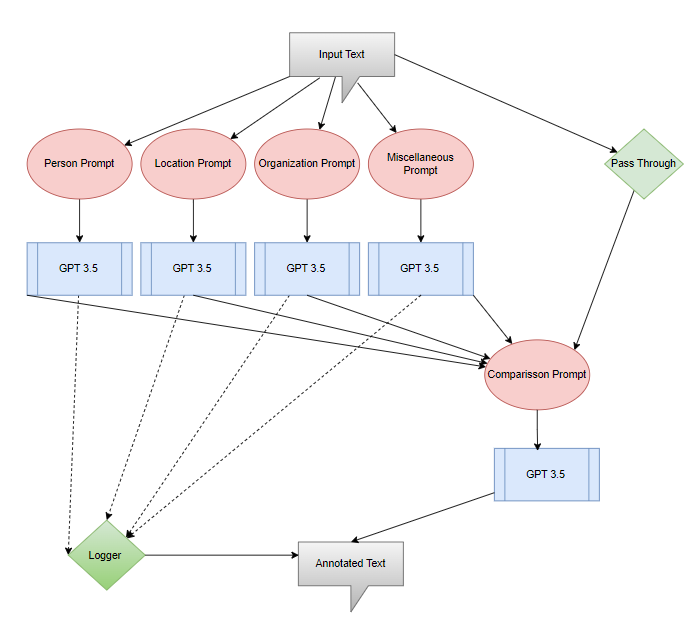

In [ ]:
from IPython.display import Image
Image("RAG_tutorial/pipeline.png")

So here we get the text send it through 4 prompts, one for each entity type. These get fed into 4 LLMs, and the responses are passed into another prompt along with the initial input. This amalgamated/ comparisson prompt is fed into another LLM for the final answer. All the intermediate LLM responses are passed forward, so the whole process is logged.

So this is a fairly complicated pipeline, that may or may not have benefits in terms of annotating our text. But the goal is that we use LCEL to connect all of these modules, make the call to the chain, and get back everything that we need.



---

### $\color{orange}{Chain}$

---

**First let's create a the prompts.**

In [ ]:
sample_input = """
The star of the Democrats has been rising in recent weeks. Kamala Harris was at the side of Joe Biden for speech in front of the National Rifle Association.\
It is a response to complains made to the UN that American's rights would be infringed on during by suggested on social media.\
Many prominant Republicans including Donald Trump are rubbing there hands in glee, at the thought of the reception the\
democrats will get in front of the NRA, especially after the criticism of the legalization of the AK47 rifle from Washington.
"""
print(sample_input)


The star of the Democrats has been rising in recent weeks. Kamala Harris was at the side of Joe Biden for speech in front of the National Rifle Association.It is a response to complains made to the UN that American's rights would be infringed on during by suggested on social media.Many prominant Republicans including Donald Trump are rubbing there hands in glee, at the thought of the reception thedemocrats will get in front of the NRA, especially after the criticism of the legalization of the AK47 rifle from Washington.



In [ ]:
person_template = """Your task is to identify the Person entities in a given input text. You should output the response in the format suggested below:\n
### Example
input: The Scientological Society is headed by Tom Cruise. The actor from the USA was in attendance at the baseball World Series over the weekend.
output: The Scientological Society is headed by @@Tom Cruise##Person. The actor from the USA was in attendance at the baseball World Series over the weekend.

### Task
input: {input}
output:
"""

person_prompt = ChatPromptTemplate.from_template(person_template)

In [ ]:
location_template = """Your task is to identify the Location entities in a given input text. You should output the response in the format suggested below:\n
### Example
input: The Scientological Society is headed by Tom Cruise. The actor from the USA was in attendance at the baseball World Series over the weekend.
output: The Scientological Society is headed by Tom Cruise. The actor from the @@USA##Location was in attendance at the baseball World Series over the weekend.

### Task
input: {input}
output:
"""

location_prompt = ChatPromptTemplate.from_template(location_template)

In [ ]:
organization_template = """Your task is to identify the Organization entities in a given input text. You should output the response in the format suggested below:\n
### Example
input: The Scientological Society is headed by Tom Cruise. The actor from the USA was in attendance at the baseball World Series over the weekend.
output: The @@Scientological Society##Organization is headed by Tom Cruise. The actor from the USA was in attendance at the baseball World Series over the weekend.

### Task
input: {input}
output:
"""

organization_prompt = ChatPromptTemplate.from_template(organization_template)

In [ ]:
miscellaneous_template = """Your task is to identify the Miscellaneous entities in a given input text. A miscellaneous entity is any entity that is not an example of\
Person, Location, or Organization entity types. You should output the response in the format suggested below:\n
### Example
input: The Scientological Society is headed by Tom Cruise. The actor from the USA was in attendance at the baseball World Series over the weekend.
output: The Scientological Society is headed by Tom Cruise. The actor from the USA was in attendance at the baseball @@World Series##Miscellaneous over the weekend.

### Task
input: {input}
output:
"""

miscellaneous_prompt = ChatPromptTemplate.from_template(miscellaneous_template)

**Lets make 4 indvidual llm chains**

In [ ]:
person_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature = 0)
organization_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature = 0)
location_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature = 0)
miscellaneous_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature = 0)

In [ ]:
from langchain_core.messages import AIMessage

In [ ]:
def parser_fn(ai_message : AIMessage):
  return ai_message.content

In [ ]:
parser = RunnableLambda(parser_fn)

In [ ]:
person_chain = person_prompt | person_llm | parser
location_chain = location_prompt | location_llm | parser
organization_chain = organization_prompt | organization_llm | parser
miscellaneous_chain = miscellaneous_prompt | miscellaneous_llm | parser

In [ ]:
person_response = person_chain.invoke(input=sample_input)

In [ ]:
print(person_response)

The star of the Democrats has been rising in recent weeks. @@Kamala Harris##Person was at the side of @@Joe Biden##Person for speech in front of the National Rifle Association. It is a response to complains made to the UN that American's rights would be infringed on during by suggested on social media. Many prominant Republicans including @@Donald Trump##Person are rubbing there hands in glee, at the thought of the reception the Democrats will get in front of the NRA, especially after the criticism of the legalization of the AK47 rifle from Washington.


**That seems to be in order, let'sl put them in a parellel with the RunnablePassthrough**

In [ ]:
input_chain = RunnableParallel(
    person_chain = person_chain,
    location_chain = location_chain,
    organization_chain = organization_chain,
    miscellaneous_chain = miscellaneous_chain,
    input = RunnablePassthrough(),
)

In [ ]:
response = input_chain.invoke(input=sample_input)

In [ ]:
response

{'person_chain': "The star of the Democrats has been rising in recent weeks. @@Kamala Harris##Person was at the side of @@Joe Biden##Person for speech in front of the National Rifle Association. It is a response to complains made to the UN that American's rights would be infringed on during by suggested on social media. Many prominant Republicans including @@Donald Trump##Person are rubbing there hands in glee, at the thought of the reception the Democrats will get in front of the NRA, especially after the criticism of the legalization of the AK47 rifle from Washington.",
 'location_chain': "The star of the Democrats has been rising in recent weeks. Kamala Harris was at the side of Joe Biden for speech in front of the @@National Rifle Association##Location. It is a response to complains made to the @@UN##Location that American's rights would be infringed on during by suggested on social media. Many prominant Republicans including Donald Trump are rubbing there hands in glee, at the tho

**Now we will implement two multipath chain that takes from this response.**

**Lets deal with the logging**

In [ ]:
import re
def parse_logs(response_dict: dict) -> dict:

  person_pattern = r'@@(.*?)##Person'
  location_pattern = r'@@(.*?)##Location'
  organization_pattern = r'@@(.*?)##Organization'
  miscellaneous_pattern = r'@@(.*?)##Miscellaneous'

  D = dict()
  D['person'] = re.findall(person_pattern, response_dict['person_chain'])
  D['location'] = re.findall(location_pattern, response_dict['location_chain'])
  D['organization'] = re.findall(organization_pattern, response_dict['organization_chain'])
  D['miscellaneous'] = re.findall(miscellaneous_pattern, response_dict['miscellaneous_chain'])

  return D

In [ ]:
parse_logs = RunnableLambda(parse_logs)

In [ ]:
parse_logs.invoke(response)

{'person': ['Kamala Harris', 'Joe Biden', 'Donald Trump'],
 'location': ['National Rifle Association', 'UN', 'Washington'],
 'organization': ['Democrats',
  'National Rifle Association',
  'Donald Trump',
  'Democrats',
  'NRA'],
 'miscellaneous': ['National Rifle Association', 'UN', 'AK47']}

**Let's do the format for the final prompt**

In [ ]:
def format_input(response_dict: dict):
  res = f"""input: {response_dict['input']}.
  Person attempt: {response_dict['person_chain']}.\n
  Location attempt: {response_dict['location_chain']}.\n
  Organization attempt: {response_dict['organization_chain']}.\n
  Miscellaneous attempt: {response_dict['miscellaneous_chain']}.\n
  """
  return res

In [ ]:
format = RunnableLambda(format_input)

In [ ]:
comparison_template = """Your task is to identify the Person, Location, Organization, and Miscellaneous entities in a given input text.\
You will be given the following information:\n\n

* The original input text.\n
* A version of the input text wherea an attempt has been made to identify Person entities.\n
* A version of the input text where an attempt has been made to identify Location entities.\n
* A version of the input text where an attempt has been made to identify Organization entities.\n
* A version of the input text where an attempt has been made to identify Miscellaneous entities.\n

You should use your judgement in creating the final 'Correct output' checking the attempts to see if they are correct, and ensuring that the output comforms to the format in the following example.\n
### Example
Input: The Scientological Society is headed by Tom Cruise. The actor from the USA was in attendance at the baseball World Series over the weekend.\n
Person attempt: The Scientological Society is headed by @@Tom Cruise##Person. The actor from the USA was in attendance at the baseball World Series over the weekend.\n
Location attempt: The Scientological Society is headed by Tom Cruise. The actor from the @@USA##Location was in attendance at the baseball World Series over the weekend.\n
Organization attempt: The @@Scientological Society##Organization is headed by Tom Cruise. The actor from the USA was in attendance at the baseball World Series over the weekend.\n
Miscellaneous attempt: The Scientological Society is headed by Tom Cruise. The actor from the USA was in attendance at the baseball @@World Series##Miscellaneous over the weekend.\n
Correct output: The @@Scientological Society##Organization is headed by @@Tom Cruise##Person. The actor from the @@USA##Location was in attendance at the baseball @@World Series##Miscellaneous over the weekend.\n\n

###Task
{input}
Correct output:
"""

comparison_prompt = ChatPromptTemplate.from_template(comparison_template)

In [ ]:
llm_comparison = ChatOpenAI(model='gpt-3.5-turbo', temperature=0)

**a final parse**

In [ ]:
def parse_final(string: str) -> dict:

  person_pattern = r'@@([a-zA-Z\s]*)##Person'
  location_pattern = r'@@([a-zA-Z\s]*)##Location'
  organization_pattern = r'@@([a-zA-Z\s]*)##Organization'
  miscellaneous_pattern = r'@@([a-zA-Z\s]*)##Miscellaneous'

  D = dict()
  D['person'] = re.findall(person_pattern, string)
  D['location'] = re.findall(location_pattern, string)
  D['organization'] = re.findall(organization_pattern, string)
  D['miscellaneous'] = re.findall(miscellaneous_pattern, string)

  return D

In [ ]:
parse_final = RunnableLambda(parse_final)

**Now the response chain**

In [ ]:
response_chain = RunnableParallel(logger= parse_logs, response =  format | comparison_prompt | llm_comparison | parser | parse_final)

**Now we can link the two ends of the chain**

In [ ]:
chain = input_chain | response_chain

In [ ]:
final_response = chain.invoke(input=sample_input)

In [ ]:
final_response.keys()

dict_keys(['logger', 'response'])

In [ ]:
final_response['logger']

{'person': ['Kamala Harris', 'Joe Biden', 'Donald Trump'],
 'location': ['National Rifle Association', 'UN', 'NRA', 'Washington'],
 'organization': ['Democrats',
  'National Rifle Association',
  'UN',
  'Republicans',
  'Democrats',
  'NRA'],
 'miscellaneous': ['National Rifle Association', 'UN', 'AK47']}

In [ ]:
final_response['response']

{'person': ['Kamala Harris', 'Joe Biden', 'Donald Trump'],
 'location': ['Washington'],
 'organization': ['Democrats',
  'National Rifle Association',
  'UN',
  'Republicans',
  'Democrats',
  'NRA'],
 'miscellaneous': []}

In [ ]:
straight_template = """Your task is to identify the Person, Location, Organization, and Miscellaneous entities in a given input text.\
Conform to the format in the following example:\n\n

### Example
Input: The Scientological Society is headed by Tom Cruise. The actor from the USA was in attendance at the baseball World Series over the weekend.\n
Output: The @@Scientological Society##Organization is headed by @@Tom Cruise##Person. The actor from the @@USA##Location was in attendance at the baseball @@World Series##Miscellaneous over the weekend.\n\n

###Task
Input: {input}\n
Output:
"""

straight_prompt = ChatPromptTemplate.from_template(comparison_template)

In [ ]:
llm = ChatOpenAI(model='gpt-3.5-turbo', temperature=0)

In [ ]:
straight_chain = straight_prompt | llm | parser | parse_final

In [ ]:
straight_chain.invoke(sample_input)

---

### $\color{orange}{Conclusion}$

---

**Apart from defining functions and prompts. We have implemented the pipeleine with the following code.**

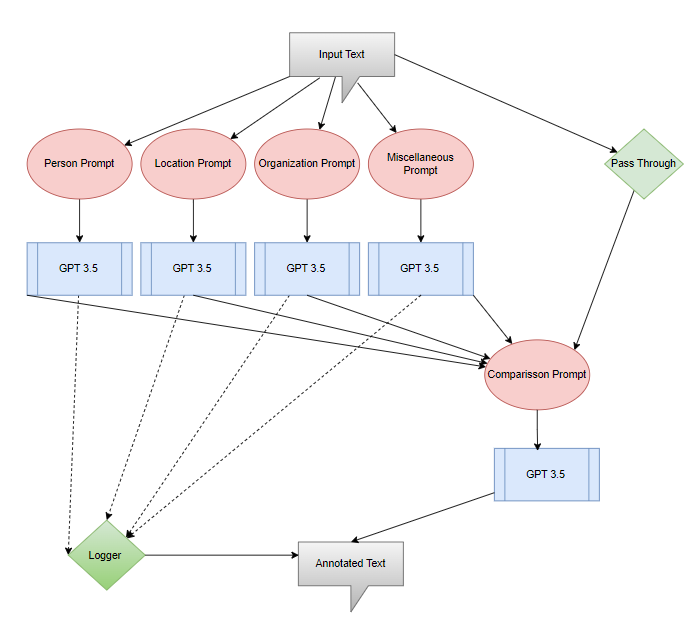

In [ ]:
from IPython.display import Image
Image("RAG_tutorial/pipeline.png")

In [ ]:
# person_chain = person_prompt | person_llm | parser
# location_chain = location_prompt | location_llm | parser
# organization_chain = organization_prompt | organization_llm | parser
# miscellaneous_chain = miscellaneous_prompt | miscellaneous_llm | parser

# input_chain = RunnableParallel(
#     person_chain = person_chain,
#     location_chain = location_chain,
#     organization_chain = organization_chain,
#     miscellaneous_chain = miscellaneous_chain,
#     input = RunnablePassthrough(),
# )

# response_chain = RunnableParallel(logger= parse_logs, response =  format | comparison_prompt | llm_comparison | parser | parse_final)

# chain = input_chain | response_chain

# chain.invoke(input=input)
